<a href="https://colab.research.google.com/github/ksj1999/DataMining_Group_Project_1/blob/main/5104_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data and library

In [ ]:
import pandas as pd
import numpy as np
#google colab import
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
seed = 42
np.random.seed(seed)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
concrete_df = pd.read_excel('/content/drive/MyDrive/FL25Courses/CSE5104/Concrete_Data.xls')
concrete_df.columns = concrete_df.columns.str.split('(').str[0].str.strip()
concrete_df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [ ]:
concrete_df.isna().sum()

,0
Cement,0
Blast Furnace Slag,0
Fly Ash,0
Water,0
Superplasticizer,0
Coarse Aggregate,0
Fine Aggregate,0
Age,0
Concrete compressive strength,0


# Train Test Split

In [ ]:
concrete_df_test = concrete_df.iloc[501:631]
print(f"test sample size: {len(concrete_df_test)}", concrete_df_test.head(), '\n\n')
concrete_df_train = concrete_df.drop(concrete_df_test.index)
print(f"train sample size: {len(concrete_df_train)}", concrete_df_train.head())

test sample size: 130      Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
501   491.0                26.0    123.0  210.0              3.93   
502   491.0                26.0    123.0  210.0              3.93   
503   491.0                26.0    123.0  210.0              3.93   
504   491.0                26.0    123.0  201.0              3.93   
505   491.0                26.0    123.0  201.0              3.93   

     Coarse Aggregate  Fine Aggregate  Age  Concrete compressive strength  
501             882.0           699.0    3                      25.609109  
502             882.0           699.0    7                      33.488834  
503             882.0           699.0   56                      59.590426  
504             822.0           699.0    3                      29.548971  
505             822.0           699.0    7                      37.921180   


train sample size: 900    Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0   540.0     

In [ ]:
predictors_train = concrete_df_train.drop(['Concrete compressive strength'], axis=1)
predictors_test = concrete_df_test.drop(['Concrete compressive strength'], axis=1)

targets_train = concrete_df_train['Concrete compressive strength']
targets_test = concrete_df_test['Concrete compressive strength']

print(f"observed targets median: {concrete_df_test['Concrete compressive strength'].median()}")
print(predictors_train.max(), predictors_train.min())

observed targets median: 25.319627148
Cement                 540.0
Blast Furnace Slag     305.3
Fly Ash                200.1
Water                  247.0
Superplasticizer        32.2
Coarse Aggregate      1145.0
Fine Aggregate         992.6
Age                    365.0
dtype: float64 Cement                102.00
Blast Furnace Slag      0.00
Fly Ash                 0.00
Water                 121.75
Superplasticizer        0.00
Coarse Aggregate      801.00
Fine Aggregate        594.00
Age                     1.00
dtype: float64


# Standarize (MinMax)

In [ ]:
def norm_data(df, train_df=None):
  if train_df is not None:
    return (df - train_df.min()) / (train_df.max() - train_df.min())
  else:
    return (df - df.min()) / (df.max() - df.min()).replace(0, 1)

In [ ]:
stand_predictors_train = norm_data(predictors_train)
#scale test set using train stats
stand_predictors_test = norm_data(predictors_test, train_df=predictors_train)
print(stand_predictors_train.max(), stand_predictors_train.min())
print(stand_predictors_test.max(), stand_predictors_test.min())
print("\nTrain data Median:")
print(stand_predictors_train.median())

Cement                1.0
Blast Furnace Slag    1.0
Fly Ash               1.0
Water                 1.0
Superplasticizer      1.0
Coarse Aggregate      1.0
Fine Aggregate        1.0
Age                   1.0
dtype: float64 Cement                0.0
Blast Furnace Slag    0.0
Fly Ash               0.0
Water                 0.0
Superplasticizer      0.0
Coarse Aggregate      0.0
Fine Aggregate        0.0
Age                   0.0
dtype: float64
Cement                0.888128
Blast Furnace Slag    1.177203
Fly Ash               0.704648
Water                 0.768463
Superplasticizer      0.338820
Coarse Aggregate      0.941860
Fine Aggregate        0.880582
Age                   1.000000
dtype: float64 Cement                0.076941
Blast Furnace Slag    0.000000
Fly Ash               0.000000
Water                 0.257485
Superplasticizer      0.000000
Coarse Aggregate      0.061047
Fine Aggregate        0.176367
Age                   0.005495
dtype: float64

Train data Median:
Cement  

In [ ]:
def mse_loss(residual):
  return np.mean(np.square(residual))

def r_squared(residual, y):
  return 1-(mse_loss(residual)/np.var(y))

def linear_regression(x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, lr: float, iter: int):
  if len(y_train.shape) == 1:
    y_train = y_train.reshape(-1, 1)
  if len(y_test.shape) == 1:
    y_test = y_test.reshape(-1, 1)
  if len(x_train.shape) == 1: #univariate case, need to reshape to col format
    x_train = x_train.reshape(-1, 1)
  if len(x_test.shape) == 1:
    x_test = x_test.reshape(-1, 1)


  w = np.random.rand(x_train.shape[1]).reshape(-1, 1)
  b = np.random.rand(1)[0] #bias should be scalar not an arry
  is_multi_variate = True if x_train.shape[1] > 1 else False
  print(f"performing multi variate regression: {is_multi_variate}")

  for i in range(iter):
    y_train_pred = np.dot(x_train, w) + b
    residual_train = y_train - y_train_pred

    w = w - lr * (np.dot(x_train.T, residual_train)/x_train.shape[0]) * -2.0
    b = b - lr * np.mean(residual_train) * -2.0

    train_loss = mse_loss(residual_train)
    train_r2 = r_squared(residual_train, y_train)
    ###
    y_test_pred = np.dot(x_test, w) + b
    residual_test = y_test - y_test_pred

    test_loss = mse_loss(residual_test)
    test_r2 = r_squared(residual_test, y_test)

    if i % 1000 == 0:
      print(f"iter: {i} mse train/test loss: {train_loss}/{test_loss}, r-squared train/test: {train_r2}/{test_r2}, bias: {b}")

  return w, b

In [ ]:
cement_train_stand = stand_predictors_train['Cement'].values
cement_test_stand = stand_predictors_test['Cement'].values
w_cement, b_cement = linear_regression(cement_train_stand, targets_train.values, cement_test_stand, targets_test.values, 1e-4, 999999)
print(f"w and b for cement predictor: {w_cement}, {b_cement}")


In [ ]:
slag_train_stand = stand_predictors_train['Blast Furnace Slag'].values
slag_test_stand = stand_predictors_test['Blast Furnace Slag'].values
w_slag, b_slag = linear_regression(slag_train_stand, targets_train.values, slag_test_stand, targets_test.values, 0.00001, 999999)
print(f"w and b for Slag predictor: {w_slag}, {b_slag}")


In [ ]:
ash_train_stand = stand_predictors_train['Fly Ash'].values
ash_test_stand = stand_predictors_test['Fly Ash'].values
w_ash, b_ash = linear_regression(ash_train_stand, targets_train.values, ash_test_stand, targets_test.values, 0.0001, 299999)
print(f"w and b for Ash predictor: {w_ash}, {b_ash}")


In [ ]:
water_train_stand = stand_predictors_train['Water'].values
water_test_stand = stand_predictors_test['Water'].values
w_water, b_water = linear_regression(water_train_stand, targets_train.values, water_test_stand, targets_test.values, 0.0001, 299999)
print(f"w and b for Water predictor: {w_water}, {b_water}")


In [ ]:
superplasticizer_train_stand = stand_predictors_train['Superplasticizer'].values
superplasticizer_test_stand = stand_predictors_test['Superplasticizer'].values
w_superplasticizer, b_superplasticizer = linear_regression(superplasticizer_train_stand, targets_train.values, superplasticizer_test_stand, targets_test.values, 0.0001, 299999)
print(f"w and b for superplasticizer predictor: {w_superplasticizer}, {b_superplasticizer}")


In [ ]:
coagg_train_stand = stand_predictors_train['Coarse Aggregate'].values
coagg_test_stand = stand_predictors_test['Coarse Aggregate'].values
w_coagg, b_coagg = linear_regression(coagg_train_stand, targets_train.values, coagg_test_stand, targets_test.values, 0.0001, 299999)
print(f"w and b for coagg predictor: {w_coagg}, {b_coagg}")


In [ ]:
fiagg_train_stand = stand_predictors_train['Fine Aggregate'].values
fiagg_test_stand = stand_predictors_test['Fine Aggregate'].values
w_fiagg, b_fiagg = linear_regression(fiagg_train_stand, targets_train.values, fiagg_test_stand, targets_test.values, 0.0001, 299999)
print(f"w and b for fiagg predictor: {w_fiagg}, {b_fiagg}")


In [ ]:
age_train_stand = stand_predictors_train['Age'].values
age_test_stand = stand_predictors_test['Age'].values
w_age, b_age = linear_regression(age_train_stand, targets_train.values, age_test_stand, targets_test.values, 0.0001, 299999)
print(f"w and b for age predictor: {w_age}, {b_age}")


Un standardized

In [ ]:
cement_train_unstand = predictors_train['Cement'].values
cement_test_unstand = predictors_test['Cement'].values
w_cement_unstand, b_cement_unstand = linear_regression(cement_train_unstand, targets_train.values, cement_test_unstand, targets_test.values, 1e-4, 399999)
print(f"w and b for cement predictor: {w_cement_unstand}, {b_cement_unstand}")



In [ ]:
cement_train_unstand = predictors_train['Blast Furnace Slag'].values
cement_test_unstand = predictors_test['Blast Furnace Slag'].values
w_cement_unstand, b_cement_unstand = linear_regression(cement_train_unstand, targets_train.values, cement_test_unstand, targets_test.values, 1e-5, 399999)
print(f"w and b for Slag predictor: {w_cement_unstand}, {b_cement_unstand}")


In [ ]:
ash_train_unstand = predictors_train['Fly Ash'].values
ash_test_unstand = predictors_test['Fly Ash'].values
w_ash_unstand, b_ash_unstand = linear_regression(ash_train_unstand, targets_train.values, ash_test_unstand, targets_test.values, 0.0001, 399999)
print(f"w and b for Ash predictor: {w_ash_unstand}, {b_ash_unstand}")


In [ ]:
water_train_unstand = predictors_train['Water'].values
water_test_unstand = predictors_test['Water'].values
w_water_unstand, b_water_unstand = linear_regression(water_train_unstand, targets_train.values, water_test_unstand, targets_test.values, 1e-5, 399999)
print(f"w and b for Water predictor: {w_water_unstand}, {b_water_unstand}")


In [ ]:
superplasticizer_train_unstand = predictors_train['Superplasticizer'].values
superplasticizer_test_unstand = predictors_test['Superplasticizer'].values
w_superplasticizer_unstand, b_superplasticizer_unstand = linear_regression(superplasticizer_train_unstand, targets_train.values, superplasticizer_test_unstand, targets_test.values, 0.0001, 399999)
print(f"w and b for Superplasticizer predictor: {w_superplasticizer_unstand}, {b_superplasticizer_unstand}")


In [ ]:
coagg_train_unstand = predictors_train['Coarse Aggregate'].values
coagg_test_unstand = predictors_test['Coarse Aggregate'].values
w_coagg_unstand, b_coagg_unstand = linear_regression(coagg_train_unstand, targets_train.values, coagg_test_unstand, targets_test.values, 1e-6, 299999)
print(f"w and b for Coarse Aggregate predictor: {w_coagg_unstand}, {b_coagg_unstand}")


In [ ]:
fiagg_train_unstand = predictors_train['Fine Aggregate'].values
fiagg_test_unstand = predictors_test['Fine Aggregate'].values
w_fiagg_unstand, b_fiagg_unstand = linear_regression(fiagg_train_unstand, targets_train.values, fiagg_test_unstand, targets_test.values, 1e-6, 299999)
print(f"w and b for Fine Aggregate predictor: {w_fiagg_unstand}, {b_fiagg_unstand}")


In [ ]:
age_train_unstand = predictors_train['Age'].values
age_test_unstand = predictors_test['Age'].values
w_age_unstand, b_age_unstand = linear_regression(age_train_unstand, targets_train.values, age_test_unstand, targets_test.values, 1e-5, 299999)
print(f"w and b for Age predictor: {w_age_unstand}, {b_age_unstand}")


# Q2 Multivariate Linear Models
Grading comment:
Update your gradient descent algorithm as needed to optimize multivariate linear regression models.

Question 2.1 Code test 1
Q2.1 Code test 1
0.5 Points
Grading comment:
Start by setting all parameters to equal 1.

Update the model with a single sample:

x = [3, 4, 5], y = 4

Use alpha = 0.1

In [ ]:
def mse_loss(residual):
  return np.mean(np.square(residual))

def r_squared(residual, y):
  return 1 - (mse_loss(residual) / np.var(y))

def linear_regression(x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, lr: float, iter: int, w_init=None, b_init=None):
  mse_list_tr = []
  r2_list_tr = []
  mse_list_te = []
  r2_list_te = []

  if len(y_train.shape) == 1:
    y_train = y_train.reshape(-1, 1)
  if len(y_test.shape) == 1:
    y_test = y_test.reshape(-1, 1)
  if len(x_train.shape) == 1:  # univariate case
    x_train = x_train.reshape(-1, 1)
  if len(x_test.shape) == 1:
    x_test = x_test.reshape(-1, 1)

  # Changed initialization part to set manually
  if w_init is not None:
    w = np.array(w_init, dtype=float).reshape(-1, 1)
  else:
    w = np.random.rand(x_train.shape[1]).reshape(-1, 1)

  if b_init is not None:
    b = float(b_init)
  else:
    b = np.random.rand(1)[0]

  is_multi_variate = x_train.shape[1] > 1
  print(f"performing multi variate regression: {is_multi_variate}")

  for i in range(iter):
    y_train_pred = np.dot(x_train, w) + b
    residual_train = y_train - y_train_pred

    w = w - lr * (np.dot(x_train.T, residual_train)/x_train.shape[0]) * -2.0
    b = b - lr * np.mean(residual_train) * -2.0

    if i % 1000 == 0:
      train_loss = mse_loss(residual_train)
      train_r2 = r_squared(residual_train, y_train)
      y_test_pred = np.dot(x_test, w) + b
      residual_test = y_test - y_test_pred
      test_loss = mse_loss(residual_test)
      test_r2 = r_squared(residual_test, y_test)

      mse_list_tr.append(train_loss)
      r2_list_tr.append(train_r2)
      mse_list_te.append(test_loss)
      r2_list_te.append(test_r2)
      print(f"iter: {i} mse train/test loss: {train_loss}/{test_loss}, r-squared train/test: {train_r2}/{test_r2}, bias: {b}")
  print(f"Final mse train/test loss: {train_loss}/{test_loss}, r-squared train/test: {train_r2}/{test_r2}, bias: {b}")


  return w, b, (mse_list_tr, r2_list_tr, mse_list_te, r2_list_te)


In [ ]:
x = np.array([[3, 4, 5]], dtype=float)
y = np.array([[4]], dtype=float)

w, b, _ = linear_regression(x, y, x, y, lr=0.1, iter=1, w_init=[1, 1, 1], b_init=1)
print("new w:", w, "new b:", b)

performing multi variate regression: True
iter: 0 mse train/test loss: 81.0/6855.839999999999, r-squared train/test: -inf/-inf, bias: -0.8
Final mse train/test loss: 81.0/6855.839999999999, r-squared train/test: -inf/-inf, bias: -0.8
new w: [[-4.4]
 [-6.2]
 [-8. ]] new b: -0.8


/tmp/ipython-input-960583513.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - (mse_loss(residual) / np.var(y))


In [ ]:
X = np.array([
    [3, 4, 4],
    [4, 2, 1],
    [10, 2, 5],
    [3, 4, 5],
    [11, 1, 1]
], dtype=float)

y = np.array([[3], [2], [8], [4], [5]], dtype=float)

w, b, _ = linear_regression(X, y, X, y, lr=0.1, iter=1, w_init=[1,1,1], b_init=1)

print("Updated weights:", w)
print("Updated bias:", b)

performing multi variate regression: True
iter: 0 mse train/test loss: 75.8/9670.28864, r-squared train/test: -16.877358490566035/-2279.728452830189, bias: -0.72
Final mse train/test loss: 75.8/9670.28864, r-squared train/test: -16.877358490566035/-2279.728452830189, bias: -0.72
Updated weights: [[-10.08]
 [ -3.52]
 [ -4.84]]
Updated bias: -0.72


# Q2.3 Set 1
Grading comment:
Using your gradient descent code, optimize a multivariate linear regression model that uses all 8 predictor variables.

Use the normalized/standardized values for the predictors, and raw values for the response variable.

Play around with hyperparameter values until you get a positive VE.

## Standarized

In [ ]:
stand_predictors_train = norm_data(predictors_train)
stand_predictors_test = norm_data(predictors_test, train_df=predictors_train)

In [ ]:
w_all, b_all, loss_lists = linear_regression(stand_predictors_train.values, targets_train.values, stand_predictors_test.values, targets_test.values, lr=1e-3, iter=40000)
print("Final weights:", w_all)
print("Final bias:", b_all)

performing multi variate regression: True
iter: 0 mse train/test loss: 1517.2994960327208/894.7995647344866, r-squared train/test: -4.476118098795355/-3.1093232149314876, bias: 0.671607222664964
iter: 1000 mse train/test loss: 238.4522981279556/258.854583867646, r-squared train/test: 0.13939670520414926/-0.18877700962492505, bias: 17.49357904525189
iter: 2000 mse train/test loss: 214.5494768602042/254.347212571241, r-squared train/test: 0.22566488923693506/-0.16807712750984027, bias: 17.657952101108783
iter: 3000 mse train/test loss: 196.95284297356608/241.2592336548103, r-squared train/test: 0.289173277367591/-0.10797122478314258, bias: 17.52972361180247
iter: 4000 mse train/test loss: 183.42700185177142/228.68035369476763, r-squared train/test: 0.33798968016885633/-0.05020333410141431, bias: 17.38772252600986
iter: 5000 mse train/test loss: 172.76908040238843/216.91385657757263, r-squared train/test: 0.37645541267394833/0.0038337281276685786, bias: 17.240900528240985
iter: 6000 mse t

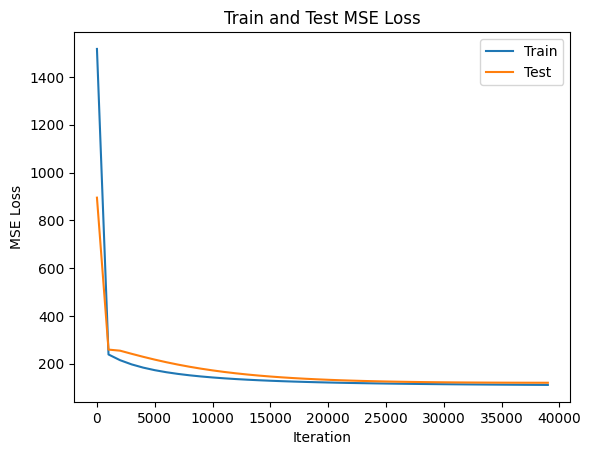

In [ ]:
import matplotlib.pyplot as plt
iter_list = [i for i in range(0, 40000, 1000)]
plt.plot(iter_list, loss_lists[0])
plt.plot(iter_list, loss_lists[2])
plt.title("Train and Test MSE Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.legend(["Train", "Test"])
plt.show()

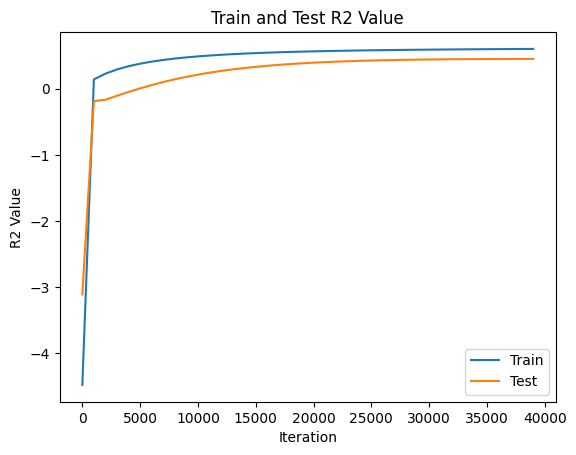

In [ ]:
plt.plot(iter_list, loss_lists[1])
plt.plot(iter_list, loss_lists[3])
plt.title("Train and Test R2 Value")
plt.xlabel("Iteration")
plt.ylabel("R2 Value")
plt.legend(["Train", "Test"])
plt.show()

## Raw

In [ ]:
X_train_raw = predictors_train.values
X_test_raw = predictors_test.values
y_train_raw = targets_train.values
y_test_raw = targets_test.values

In [ ]:
w_raw, b_raw = linear_regression(X_train_raw, y_train_raw, X_test_raw, y_test_raw,lr=1e-7, iter=40000)
print("Final weights:", w_raw)
print("Final bias:", b_raw)

## Graphs for part C

In [ ]:
def linear_prediction(x, w, b):
  return np.dot(x.T,w)+b

multi_var_w = w_all
multi_var_b = b_all
x = [0.3715,0.1378,0.0,0.4789,0.231,0.4827,0.4627,0.074]
x = np.array(x, dtype=float).reshape(-1, 1)
print(x.shape)

(8, 1)


In [ ]:
# Cement
# Blast Furnace Slag    0.137832
# Fly Ash               0.000000
# Water                 0.478962
# Superplasticizer      0.231056
# Coarse Aggregate      0.482791
# Fine Aggregate        0.462745
# Age                   0.074176

# Reshape the input to match the expected shape of the linear_prediction function
age_vars = np.linspace(1, 360, num=10)
supr_plast_vars = np.linspace(0, 50, num=15)
water_vars = np.linspace(50, 400, num=15)
cement_vars = np.linspace(100, 600, num = 10)
train_max_vals = predictors_train.max().to_numpy()
train_min_vals = predictors_train.min().to_numpy()

pred_list = []
var_index = 7

for a_var in age_vars:
  a_var_stand = (a_var - train_min_vals[var_index]) / (train_max_vals[var_index] - train_min_vals[var_index])
  x[var_index] = a_var_stand
  pred = linear_prediction(x=x, w=multi_var_w, b=multi_var_b)
  pred = pred[0][0]
  pred_list.append(pred)

print(age_vars)
print(pred_list)

[  1.          40.88888889  80.77777778 120.66666667 160.55555556
 200.44444444 240.33333333 280.22222222 320.11111111 360.        ]
[np.float64(49.37574024879367), np.float64(53.24454049961003), np.float64(57.113340750426396), np.float64(60.98214100124276), np.float64(64.85094125205913), np.float64(68.71974150287548), np.float64(72.58854175369186), np.float64(76.4573420045082), np.float64(80.32614225532457), np.float64(84.19494250614093)]


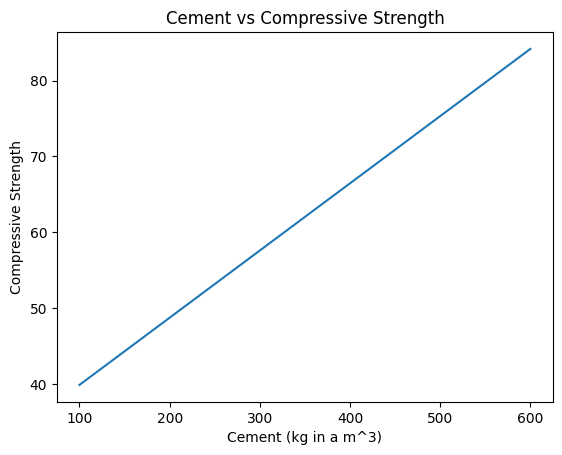

In [ ]:
plt.plot(cement_vars, pred_list)
plt.xlabel("Cement (kg in a m^3)")
plt.ylabel("Compressive Strength")
plt.title("Cement vs Compressive Strength")
plt.show()

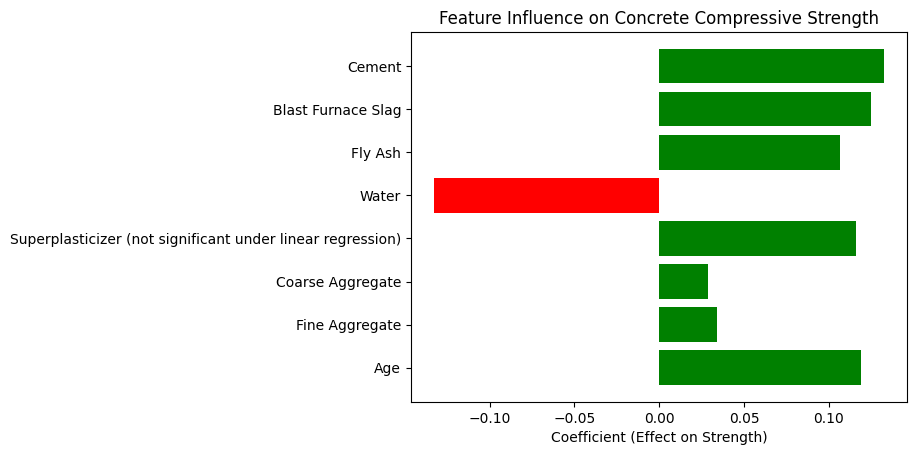

In [ ]:
import matplotlib.pyplot as plt

features = ["Cement", "Blast Furnace Slag", "Fly Ash", "Water", "Superplasticizer (not significant under linear regression)", "Coarse Aggregate", "Fine Aggregate", "Age"]
coeffs = [0.1328, 0.1250, 0.1067, -0.1331, 0.1162, 0.0286, 0.0341, 0.1188]

plt.barh(features, coeffs, color=['green' if c > 0 else 'red' for c in coeffs])
plt.xlabel("Coefficient (Effect on Strength)")
plt.title("Feature Influence on Concrete Compressive Strength")
plt.gca().invert_yaxis()
plt.show()
